In [1]:
# import packages
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# import nbody6tools reader to read data
from nbody6tools import Reader

# import nbody62spisea to retrieve star ages
from nbody62spisea import converter

/home/wyz5rge/.local/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /scratch/wyz5rge/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


## Set up parameters, create isochrone grid

In [2]:
# define isochrone parameters
AKs = 0
dist = 410
evo_model = evolution.Baraffe15()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F115W', 'jwst,F182M']
filters = ['m_jwst_F115W', 'm_jwst_F182M']
iso_dir = 'isochrones/'
metallicity = 0

In [3]:
# read nbody data
path_to_data = '../../../../../../storage/jfarias/Data/Orion/massive_clusters/M3000new/sigma0p1/fiducial/sfe_ff030/00/'
snapshot = Reader.read_snapshot(path_to_data, time = 20)

# convert snapshot values from nbody units to astrophysical, extract masses
snapshot.to_physical()

# read ages for simulated stars
cluster_table = converter.to_spicea_table(snapshot)

print(cluster_table)

        mass        isMultiple        compMass            systemMass               e                 log_a               age        
------------------- ---------- --------------------- ------------------- --------------------- ------------------ ------------------
0.38677660467533986        0.0                    [] 0.38677660467533986                   nan                nan  19.26224057185385
0.09231783947974262        0.0                    [] 0.09231783947974262                   nan                nan   19.5514140105106
 36.123316292283796        0.0                    []  36.123316292283796                   nan                nan 20.005693435668945
  6.392950509328739        0.0                    []   6.392950509328739                   nan                nan 19.370763950562367
                ...        ...                   ...                 ...                   ...                ...                ...
  6.934423197710811        1.0 [0.06417945167258093]   6.998602649383

/scratch/wyz5rge/TurbulentClusterModel/nbody62spisea/converter.py:231: RuntimeWarning: divide by zero encountered in log10
  log_a = numpy.concatenate( [numpy.full(len(singles),numpy.nan), numpy.log10(bdict['semi']) ] )


In [4]:
masses = cluster_table['mass']
level_ages = cluster_table['age']

for i in range(len(level_ages)):
    level_ages[i] = level_ages[i] * 1e6

# convert log ages from log(Myr) to log(yr)
log_ages = np.log10(level_ages)

# print(log_ages)
print("Min log age = " + str(min(log_ages)))
print("Max log age = " + str(max(log_ages)))

# print(level_ages)
print("Min level age = " + str(min(level_ages)))
print("Max level age = " + str(max(level_ages)))

Min log age = 7.283549025426875
Max log age = 7.3011536094548415
Min level age = 19210958.12830047
Max level age = 20005693.435668945


In [5]:
# find index of first binary, create array of companion masses
first_binary = 0
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        first_binary = i
        break
print(first_binary)

compMasses = []
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        compMasses.append(cluster_table['compMass'][i][0])
print(compMasses)

1383
[0.011730564894188028, 0.05478057038822213, 0.06485943635188168, 0.12253409660171809, 0.04859034515867186, 0.15443180140146529, 0.0985120249691716, 0.033028117552569486, 0.07296174171872727, 1.1957055640931418, 2.029321470134261, 0.08446092045083976, 0.057592704150663705, 0.2721473693697683, 0.028782306982601466, 0.011667292633636295, 0.34500615375747046, 0.11102967103077452, 0.05943886385861074, 0.017457505428094936, 0.06946304860174829, 0.1207850333696815, 0.010195908833252887, 0.010522529156571857, 0.08959545040191466, 0.20713306040726343, 0.04773619825452143, 0.1117515039037843, 0.4894471940265139, 0.02526523877381286, 0.07901504357069017, 0.12227410078048706, 0.32250139117240906, 0.23865769803524017, 0.23228810727596283, 0.08560962229967117, 0.10158726633004997, 0.10317263136259226, 0.03547369130947629, 0.23702588980017325, 0.22238589823246002, 0.024706430733203888, 2.8133962336914204, 0.022072263062000275, 0.05710261381527612, 0.010722441606012696, 0.2922457793227283, 0.0198

In [6]:
start = (min(level_ages) // 0.5e6) * 0.5e6
end = (max(level_ages) // 0.5e6) * 0.5e6 + 2 * 0.5e6
increment = 0.5e6  # 500,000

# Create age arrays
level_age_arr = np.arange(start, end, increment)
log_age_arr = np.log10(level_age_arr)

print(log_age_arr)
print(level_age_arr)

[7.2787536  7.29003461 7.30103    7.31175386]
[19000000. 19500000. 20000000. 20500000.]


In [7]:
# create isochrone grid - if this is the first time, then this is going to take an hour lmfao
instances = np.empty(len(log_age_arr), dtype=object)

for i in range(len(log_age_arr)):
    my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    instances[i] = my_iso
        
print("isochrone generation done")

isochrone generation done


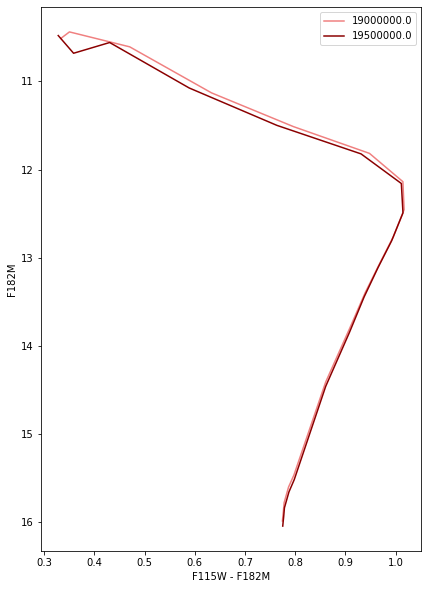

In [8]:
# identify array indeces, create array for labels and colors
idx_arr = range(0, len(log_age_arr))
if len(idx_arr) > 3:
    idx_arr = idx_arr[::2]

# Plot CMD
fig, axes = py.subplots(figsize=(15, 10))
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

In [9]:
import sys
sys.path.append('/scratch/wyz5rge/synthetic-hr/12-18')
import interpolatorExp as interpolator

level_ages_myr = level_ages / 1e6
# print(level_ages_myr)

# create array of stars
stars = np.empty(len(cluster_table), dtype=object)

# perform interpolation for each star
for i in range(len(stars)):
    # print(str(i) + " " + str(level_ages_myr[i]) + " " + str(masses[i]))
    stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
# convert luminosity values to solar luminosities
watts_to_lsun = 1.0 / (3.846e26) # conversion factor for watts to Lsun

for i in range(len(stars)):
    if stars[i] is None:
        continue
    stars[i][0] = stars[i][0] * watts_to_lsun
    
for i in range(len(stars)):
    print(stars[i])

Desired mass 36.123316292283796 is outside the range of the isochrone.
Desired mass 36.123316292283796 is outside the range of the isochrone.
Desired mass 6.392950509328739 is outside the range of the isochrone.
Desired mass 6.392950509328739 is outside the range of the isochrone.
Desired mass 0.023830331502852638 is outside the range of the isochrone.
Desired mass 0.023830331502852638 is outside the range of the isochrone.
Desired mass 0.01885011874476299 is outside the range of the isochrone.
Desired mass 0.01885011874476299 is outside the range of the isochrone.
Desired mass 23.0114803314209 is outside the range of the isochrone.
Desired mass 23.0114803314209 is outside the range of the isochrone.
Desired mass 19.128720071850825 is outside the range of the isochrone.
Desired mass 19.128720071850825 is outside the range of the isochrone.
Desired mass 0.05258214792958986 is outside the range of the isochrone.
Desired mass 0.05258214792958986 is outside the range of the isochrone.
Desi

Desired mass 0.03998478414697443 is outside the range of the isochrone.
Desired mass 0.03998478414697443 is outside the range of the isochrone.
Desired mass 0.03258253870323046 is outside the range of the isochrone.
Desired mass 0.03258253870323046 is outside the range of the isochrone.
Desired mass 0.018889286387385518 is outside the range of the isochrone.
Desired mass 0.018889286387385518 is outside the range of the isochrone.
Desired mass 0.03870388679677665 is outside the range of the isochrone.
Desired mass 0.03870388679677665 is outside the range of the isochrone.
Desired mass 0.0617323865256662 is outside the range of the isochrone.
Desired mass 0.0617323865256662 is outside the range of the isochrone.
Desired mass 0.03653154909159941 is outside the range of the isochrone.
Desired mass 0.03653154909159941 is outside the range of the isochrone.
Desired mass 0.06506475063329734 is outside the range of the isochrone.
Desired mass 0.06506475063329734 is outside the range of the iso

Desired mass 0.02182996758653066 is outside the range of the isochrone.
Desired mass 0.02182996758653066 is outside the range of the isochrone.
Desired mass 0.03574866448183103 is outside the range of the isochrone.
Desired mass 0.03574866448183103 is outside the range of the isochrone.
Desired mass 0.018773101954199654 is outside the range of the isochrone.
Desired mass 0.018773101954199654 is outside the range of the isochrone.
Desired mass 0.024440387058807914 is outside the range of the isochrone.
Desired mass 0.024440387058807914 is outside the range of the isochrone.
Desired mass 0.04522356839330978 is outside the range of the isochrone.
Desired mass 0.04522356839330978 is outside the range of the isochrone.
Desired mass 0.03273091771230353 is outside the range of the isochrone.
Desired mass 0.03273091771230353 is outside the range of the isochrone.
Desired mass 0.023744913919861096 is outside the range of the isochrone.
Desired mass 0.023744913919861096 is outside the range of t

Desired mass 0.026238116951510914 is outside the range of the isochrone.
Desired mass 0.026238116951510914 is outside the range of the isochrone.
Desired mass 1.5114231444029542 is outside the range of the isochrone.
Desired mass 1.5114231444029542 is outside the range of the isochrone.
Desired mass 0.06759901587707393 is outside the range of the isochrone.
Desired mass 0.06759901587707393 is outside the range of the isochrone.
Desired mass 0.059914424814746466 is outside the range of the isochrone.
Desired mass 0.059914424814746466 is outside the range of the isochrone.
Desired mass 0.030252250373971386 is outside the range of the isochrone.
Desired mass 0.030252250373971386 is outside the range of the isochrone.
Desired mass 0.015840843921606628 is outside the range of the isochrone.
Desired mass 0.015840843921606628 is outside the range of the isochrone.
Desired mass 0.04395424311741485 is outside the range of the isochrone.
Desired mass 0.04395424311741485 is outside the range of t

Desired mass 0.024127682144245224 is outside the range of the isochrone.
Desired mass 0.024127682144245224 is outside the range of the isochrone.
Desired mass 0.025662683570645117 is outside the range of the isochrone.
Desired mass 0.025662683570645117 is outside the range of the isochrone.
Desired mass 0.023111166638396876 is outside the range of the isochrone.
Desired mass 0.023111166638396876 is outside the range of the isochrone.
Desired mass 0.027857994225167014 is outside the range of the isochrone.
Desired mass 0.027857994225167014 is outside the range of the isochrone.
Desired mass 0.059862145954433434 is outside the range of the isochrone.
Desired mass 0.059862145954433434 is outside the range of the isochrone.
Desired mass 0.014003782176373316 is outside the range of the isochrone.
Desired mass 0.014003782176373316 is outside the range of the isochrone.
Desired mass 0.06059559575871986 is outside the range of the isochrone.
Desired mass 0.06059559575871986 is outside the rang

Desired mass 0.022154921770031803 is outside the range of the isochrone.
Desired mass 0.022154921770031803 is outside the range of the isochrone.
Desired mass 0.027137834813723453 is outside the range of the isochrone.
Desired mass 0.027137834813723453 is outside the range of the isochrone.
Desired mass 0.057624810779400425 is outside the range of the isochrone.
Desired mass 0.057624810779400425 is outside the range of the isochrone.
Desired mass 0.013347399043755268 is outside the range of the isochrone.
Desired mass 0.013347399043755268 is outside the range of the isochrone.
Desired mass 1.7912065049358872 is outside the range of the isochrone.
Desired mass 1.7912065049358872 is outside the range of the isochrone.
Desired mass 0.03346671548707995 is outside the range of the isochrone.
Desired mass 0.03346671548707995 is outside the range of the isochrone.
Desired mass 0.019842533620072145 is outside the range of the isochrone.
Desired mass 0.019842533620072145 is outside the range of

Desired mass 0.018215254284522923 is outside the range of the isochrone.
Desired mass 0.018215254284522923 is outside the range of the isochrone.
Desired mass 0.048346319378397375 is outside the range of the isochrone.
Desired mass 0.048346319378397375 is outside the range of the isochrone.
Desired mass 0.05446313146477182 is outside the range of the isochrone.
Desired mass 0.05446313146477182 is outside the range of the isochrone.
Desired mass 0.05765992406942315 is outside the range of the isochrone.
Desired mass 0.05765992406942315 is outside the range of the isochrone.
Desired mass 0.019418187337823505 is outside the range of the isochrone.
Desired mass 0.019418187337823505 is outside the range of the isochrone.
Desired mass 0.038802118316161954 is outside the range of the isochrone.
Desired mass 0.038802118316161954 is outside the range of the isochrone.
Desired mass 0.058254751434394195 is outside the range of the isochrone.
Desired mass 0.058254751434394195 is outside the range 

Desired mass 0.03763033303195965 is outside the range of the isochrone.
Desired mass 0.03763033303195965 is outside the range of the isochrone.
Desired mass 0.031391282562053695 is outside the range of the isochrone.
Desired mass 0.031391282562053695 is outside the range of the isochrone.
Desired mass 0.03659449340940833 is outside the range of the isochrone.
Desired mass 0.03659449340940833 is outside the range of the isochrone.
Desired mass 0.06949773465620199 is outside the range of the isochrone.
Desired mass 0.06949773465620199 is outside the range of the isochrone.
Desired mass 0.042475034337297046 is outside the range of the isochrone.
Desired mass 0.042475034337297046 is outside the range of the isochrone.
Desired mass 0.03478509056962564 is outside the range of the isochrone.
Desired mass 0.03478509056962564 is outside the range of the isochrone.
Desired mass 2.0229362187947455 is outside the range of the isochrone.
Desired mass 2.0229362187947455 is outside the range of the i

Desired mass 0.02816610837040747 is outside the range of the isochrone.
Desired mass 0.02816610837040747 is outside the range of the isochrone.
Desired mass 0.035495894717837706 is outside the range of the isochrone.
Desired mass 0.035495894717837706 is outside the range of the isochrone.
Desired mass 5.54126185822786 is outside the range of the isochrone.
Desired mass 5.54126185822786 is outside the range of the isochrone.
Desired mass 0.03996687002161633 is outside the range of the isochrone.
Desired mass 0.03996687002161633 is outside the range of the isochrone.
Desired mass 0.029020323990275775 is outside the range of the isochrone.
Desired mass 0.029020323990275775 is outside the range of the isochrone.
Desired mass 0.03137492416049425 is outside the range of the isochrone.
Desired mass 0.03137492416049425 is outside the range of the isochrone.
Desired mass 0.05677592998681154 is outside the range of the isochrone.
Desired mass 0.05677592998681154 is outside the range of the isoch

Desired mass 0.0625810120559439 is outside the range of the isochrone.
Desired mass 0.0625810120559439 is outside the range of the isochrone.
Desired mass 0.016389793364149464 is outside the range of the isochrone.
Desired mass 0.016389793364149464 is outside the range of the isochrone.
Desired mass 0.02852220201793417 is outside the range of the isochrone.
Desired mass 0.02852220201793417 is outside the range of the isochrone.
Desired mass 1.4927376416858829 is outside the range of the isochrone.
Desired mass 1.4927376416858829 is outside the range of the isochrone.
Desired mass 0.039934786865676516 is outside the range of the isochrone.
Desired mass 0.039934786865676516 is outside the range of the isochrone.
Desired mass 0.05764317452946886 is outside the range of the isochrone.
Desired mass 0.05764317452946886 is outside the range of the isochrone.
Desired mass 0.020560124579012903 is outside the range of the isochrone.
Desired mass 0.020560124579012903 is outside the range of the i

[0.005427672917892191, 2959.12, 4.408, 16.699, 15.923]
None
[0.04642030597490837, 3438.414, 4.409, 14.561, 13.64]
[0.05863676242441759, 3509.801, 4.416, 14.323, 13.381]
[0.16567685022683037, 3965.022, 4.435, 13.366, 12.351]
None
[0.016123607579990932, 3176.896, 4.41, 15.704, 14.869]
None
None
[0.020949961344537645, 3257.534, 4.416, 15.343, 14.483]
[0.007523378356627914, 3044.221, 4.428, 16.372, 15.578]
None
[0.017651441480926396, 3206.984, 4.42, 15.588, 14.745]
[0.031825207631689015, 3339.51, 4.404, 14.949, 14.06]
[0.043928404482233244, 3423.501, 4.407, 14.612, 13.695]
None
[0.00568830421798628, 2974.148, 4.416, 16.652, 15.876]
[0.008726539981485692, 3066.471, 4.418, 16.242, 15.442]
None
[0.006553266539277036, 3001.979, 4.408, 16.509, 15.727]
None
[0.018773606416317746, 3216.415, 4.408, 15.511, 14.664]
None
[0.016533675883070763, 3182.71, 4.41, 15.674, 14.838]
[0.005166428312692656, 2947.007, 4.407, 16.75, 15.974]
None
None
[0.0066350263075601375, 3003.911, 4.407, 16.496, 15.714]
None


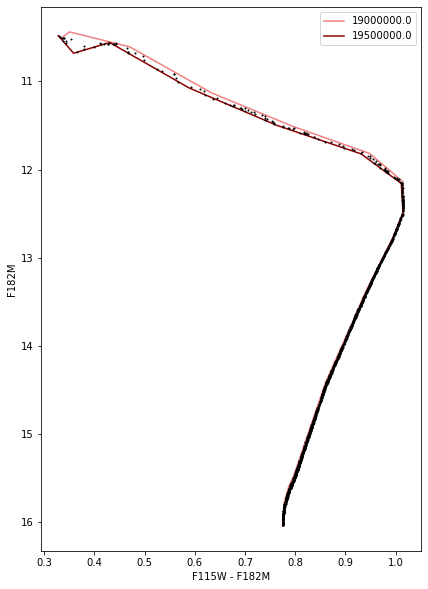

In [10]:
fig, axes = py.subplots(figsize=(15, 10))

# plot CMD
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

for i in range(len(stars)):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
